# Calculates daily average sentiment indicators


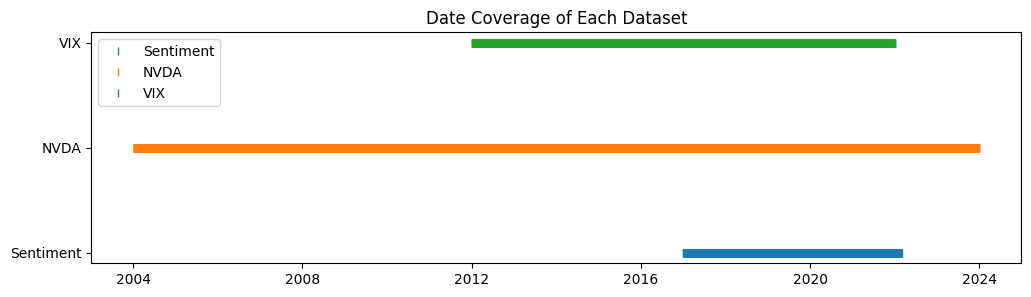

After inner join, total days: 1259
index                  0
avg_sentiment_score    0
model_type             0
nvda_close             0
nvda_return            0
vix_close              0
dtype: int64
All overlap dates (total 1259):
2017-01-03
2017-01-04
2017-01-05
2017-01-06
2017-01-09
2017-01-10
2017-01-11
2017-01-12
2017-01-13
2017-01-17
2017-01-18
2017-01-19
2017-01-20
2017-01-23
2017-01-24
2017-01-25
2017-01-26
2017-01-27
2017-01-30
2017-01-31
2017-02-01
2017-02-02
2017-02-03
2017-02-06
2017-02-07
2017-02-08
2017-02-09
2017-02-10
2017-02-13
2017-02-14
2017-02-15
2017-02-16
2017-02-17
2017-02-21
2017-02-22
2017-02-23
2017-02-24
2017-02-27
2017-02-28
2017-03-01
2017-03-02
2017-03-03
2017-03-06
2017-03-07
2017-03-08
2017-03-09
2017-03-10
2017-03-13
2017-03-14
2017-03-15
2017-03-16
2017-03-17
2017-03-20
2017-03-21
2017-03-22
2017-03-23
2017-03-24
2017-03-27
2017-03-28
2017-03-29
2017-03-30
2017-03-31
2017-04-03
2017-04-04
2017-04-05
2017-04-06
2017-04-07
2017-04-10
2017-04-11
2017-04-12


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# read sentiment score
daily_sent = pd.read_csv("../2_data/daily_sentiment_vader.csv", parse_dates=["date"])
daily_sent = daily_sent.set_index("date")



# read data
nvda = pd.read_csv("../2_data/nvidia_stock_prices.csv", parse_dates=["Date"])
nvda = nvda.rename(columns={"Close": "nvda_close"})
nvda = nvda.sort_values("Date")
nvda["nvda_return"] = nvda["nvda_close"].pct_change()
nvda_close = nvda[["Date", "nvda_close", "nvda_return"]].set_index("Date")
nvda_close = nvda_close.dropna(subset=["nvda_return"])

vix = pd.read_csv("../2_data/vix_data.csv", parse_dates=["Date"])
vix = vix.rename(columns={"Close": "vix_close"})
vix = vix.sort_values("Date")
vix_close = vix[["Date", "vix_close"]].set_index("Date")



# visualization
plt.figure(figsize=(12, 3))
plt.plot(sorted(sent_dates), [1]*len(sent_dates), '|', label='Sentiment')
plt.plot(sorted(nvda_dates), [2]*len(nvda_dates), '|', label='NVDA')
plt.plot(sorted(vix_dates), [3]*len(vix_dates), '|', label='VIX')
plt.yticks([1,2,3], ['Sentiment', 'NVDA', 'VIX'])
plt.title("Date Coverage of Each Dataset")
plt.legend()
plt.show()

#Inner Merge
merged_inner = (daily_sent
    .join(nvda_close[["nvda_close", "nvda_return"]], how="inner")
    .join(vix_close, how="inner")
    .reset_index()
)
print("After inner join, total days:", len(merged_inner))
print(merged_inner.isnull().sum())


if 'index' in merged_inner.columns:
    merged_inner = merged_inner.rename(columns={'index': 'date'})

merged_inner.to_csv("../2_data/sentiment_price_vix_inner_aligned.csv", index=False)


# print(merged_inner)
sent_dates = set(daily_sent.index.date)
nvda_dates = set(nvda_close.index.date)
vix_dates = set(vix_close.index.date)


overlap_dates = sorted(sent_dates & nvda_dates & vix_dates)

print("All overlap dates (total {}):".format(len(overlap_dates)))
for d in overlap_dates:
    print(d)